### 导入需要的包

In [15]:
import torch
import gym
import numpy as np
import seaborn as sns
from torch import nn
from matplotlib import pyplot as plt
from torch.nn import functional as f
from torch.distributions import Categorical,Normal
from torch.utils.tensorboard import SummaryWriter
from collections import deque

### 定义演员-评论家网络
对于gym中简单的环境，简单的线性层+激活层就可以进行学习，在这里针对离散动作空间和连续动作空间设计不同的actor网络。

In [2]:
class ActorSoftmax(nn.Module):
    '''针对离散动作空间下的actor网络'''
    def __init__(self,input_dim,output_dim,hidden_size=128):
        super(ActorSoftmax, self).__init__()
        self.fc1 = nn.Linear(input_dim,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,output_dim)

    def forward(self, x):
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        probs = f.softmax(self.fc3(x),dim=1)
        return probs

class ActorNormal(nn.Module):
    '''针对连续动作空间下的actor网络'''
    def __init__(self,input_dim,output_dim,hidden_size=128):
        super(ActorNormal,self).__init__()
        self.fc1 = nn.Linear(input_dim,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,output_dim)
    
    def forward(self,x):
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        mu = torch.tanh(self.fc3(x)) # mean of distribution
        sigma = f.softplus(self.fc3(x))+0.001 # std of normal distribution
        sigma = torch.clamp(sigma, min=-0.25, max=0.25)
        return mu,sigma
        
class Critic(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=128):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        value = self.fc3(x)
        return value

### 定义智能体-A2C算法的实现
首先定义一个缓冲区，用于收集模型展开n_steps的轨迹，环境会根据选取的动作返回新的观测状态、奖励等信息，将这些信息存储在缓冲区中，等到智能体执行n步动作之后，将所有信息取出来进行之后的计算。

In [3]:
class PGReplay:
    '''replay buffer for policy gradient based methods'''
    def __init__(self):
        self.buffer = deque() # create a buffer
    def push(self,transitions):
        self.buffer.append(transitions) # save transitions
    def sample(self):
        batch = list(self.buffer)
        return zip(*batch) # extract all transitions 
    def clear(self):
        self.buffer.clear()

A2C算法的基本原理是在演员-评论家算法的基础上引入优势函数的概念。评论家是一个函数逼近器，输入当前观测到的状态，输出评分值，也就是Q值。而Q值实际上可以分解为两部分，即Q(s,a)=A(s,a)+V(s)。其中A(s,a)即为优势函数，评价的是在给定状态下当前选定动作相较于其他动作的好坏。A2C算法的核心就在于让评论家学习A(s,a)而不再是学习Q(s,a)。

In [4]:
class Agent:
    def __init__(self, cfg):
        self.gamma = cfg.gamma
        self.entropy_coef = cfg.entropy_coef
        self.device = torch.device(cfg.device)
        self.continuous = cfg.continuous
        if hasattr(cfg,'action_bound'):
            self.action_bound = cfg.action_bound
        env = gym.make(cfg.env_id)
        n_states = env.observation_space.shape[0]
        n_actions = env.action_space.n
        self.actor = ActorSoftmax(n_states,n_actions,hidden_size=cfg.actor_hidden_dim).to(self.device)
        self.critic = Critic(n_states,1,hidden_size=cfg.critic_hidden_dim).to(self.device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=cfg.actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=cfg.critic_lr)
        self.memory = PGReplay()
        self.sample_count = 0
        self.update_freq = cfg.update_freq
        
    def sample_action(self,state):
        self.sample_count += 1
        if self.continuous:
            state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
            mu, sigma = self.actor(state)
            dist = Normal(self.action_bound * mu.view(1,), sigma.view(1,))
            action = dist.sample()
            value = self.critic(state)
            self.value = value.detach().cpu().numpy().squeeze(0)[0] # detach() to avoid gradient
            self.log_prob = dist.log_prob(action).squeeze(dim=0) # Tensor([0.])
            self.entropy = dist.entropy().cpu().detach().numpy().squeeze(0) # detach() to avoid gradient
            return action.cpu().detach().numpy()
        else:
            state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
            probs = self.actor(state)
            dist = Categorical(probs)
            action = dist.sample() # Tensor([0])
            # value = self.critic(state)
            return action.detach().cpu().numpy().item()
        
    @torch.no_grad()
    def predict_action(self,state):
        if self.continuous:
            state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
            mu, sigma = self.actor(state)
            dist = Normal(self.action_bound * mu.view(1,), sigma.view(1,))
            action = dist.sample()
            return action.cpu().detach().numpy()
        else:
            state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
            probs = self.actor(state)
            dist = Categorical(probs)
            action = dist.sample()
            return action.detach().cpu().numpy().item()
        
    def compute_returns(self, next_value, rewards, masks):
        '''monte carlo estimate of state rewards'''
        returns = torch.zeros_like(rewards)
        R = next_value
        for t in reversed(range(len(rewards))):
            R = rewards[t] + self.gamma * R * masks[t]
            returns[t] = R
        # Normalizing the rewards:
        returns = torch.tensor(returns, device=self.device, dtype=torch.float32).unsqueeze(1)
        returns = (returns - returns.mean()) / (returns.std() + 1e-5) # 1e-5 to avoid division by 
        return returns  
        
    def update(self,next_state):
        # update policy every n steps
        if self.sample_count % self.update_freq != 0:
            return
        # print("update policy")
        states, actions, rewards, masks = self.memory.sample()
        # convert to tensor
        states = torch.tensor(np.array(states), device=self.device, dtype=torch.float32)
        actions = torch.tensor(np.array(actions), device=self.device, dtype=torch.float32)
        rewards = torch.tensor(np.array(rewards), device=self.device, dtype=torch.float32)
        masks = torch.tensor(np.array(masks), device=self.device, dtype=torch.float32)
        # compute returns
        if next_state is not None:
            next_state = torch.tensor(next_state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
            next_value = self.critic(next_state).detach().cpu().numpy().squeeze(0)[0]
        else:
            next_value = 0 # terminal state
        returns = self.compute_returns(next_value,rewards,masks)
        values = self.critic(states)
        advantages = returns - values.detach()
        probs = self.actor(states)
        dist = Categorical(probs)
        log_probs = dist.log_prob(actions).unsqueeze(dim=1) # log_probs.shape = (batch_size,1), which is the same as advantages.shape
        actor_loss = (-log_probs*advantages).mean()+ self.entropy_coef * dist.entropy().mean()
        critic_loss = (returns-values).pow(2).mean()
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        critic_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()
        self.memory.clear() # clear memory

### 定义一个回合的训练过程和测试过程

In [5]:
def train_one_episode(env, agent, cfg): 
    ep_reward = 0  # reward per episode
    ep_step = 0
    env.seed(cfg.seed)
    state = env.reset()  # reset and obtain initial state
    for _ in range(cfg.max_steps):
        ep_step += 1
        action = agent.sample_action(state)  # sample action
        if cfg.new_step_api:
            next_state, reward, terminated, truncated , info = env.step(action)  # update env and return transitions under new_step_api of OpenAI Gym
        else:
            next_state, reward, terminated, info = env.step(action)  # update env and return transitions under old_step_api of OpenAI Gym
        agent.memory.push((state,action,reward,1-terminated))
        if terminated:
            agent.update(None)
        else:
            agent.update(next_state)
        state = next_state  # update next state for env
        ep_reward += reward  #
        if terminated:
            break
    res = {'ep_reward':ep_reward,'ep_step':ep_step}
    return agent,res  

In [6]:
def test_one_episode(env, agent, cfg):
    ep_reward = 0  # reward per episode
    ep_step = 0
    env.seed(cfg.seed)
    state = env.reset()  # reset and obtain initial state
    for _ in range(cfg.max_steps):
        if cfg.render:
            env.render()
        ep_step += 1
        action = agent.predict_action(state)  # sample action
        if cfg.new_step_api:
            next_state, reward, terminated, truncated , info = env.step(action)  # update env and return transitions under new_step_api of OpenAI Gym
        else:
            next_state, reward, terminated, info = env.step(action) # update env and return transitions under old_step_api of OpenAI Gym
        state = next_state  # update next state for env
        ep_reward += reward  #
        if terminated:
            break
    res = {'ep_reward':ep_reward,'ep_step':ep_step}
    return agent,res
   

In [7]:
def evaluate(cfg, env, agent):
    sum_eval_reward = 0
    for _ in range(cfg.eval_eps):
        _, res = test_one_episode(env, agent, cfg)
        sum_eval_reward += res['ep_reward']
    mean_eval_reward = sum_eval_reward / cfg.eval_eps
    return mean_eval_reward

In [8]:
def smooth(data,weight=0.9):
    last = data[0]
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed
def plot_rewards(rewards, title='learning curve', show_fig=True):
    plt.figure()
    plt.title(f'{title}')
    plt.xlabel('episodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards),label='smoothed')
    plt.legend()
    if show_fig:
        plt.show()

### 定义总的训练和测试过程

In [2]:
def train(cfg):
    env = gym.make(cfg.env_id)
    agent = Agent(cfg)
    rewards = [] # record rewards for all episodes
    steps = [] # record steps for all episodes
    # create tensorboard
    tb_writter = SummaryWriter('./logs')
    best_ep_rewards = -float('inf')
    print('start training!')
    for i_ep in range(cfg.train_eps):
        agent, res = train_one_episode(env, agent, cfg)
        ep_reward = res['ep_reward']
        ep_step = res['ep_step']
        print(f'Episode:{i_ep+1}/{cfg.train_eps},Rewards:{ep_reward},Steps:{ep_step}')
        for key, value in res.items():
            tb_writter.add_scalar(tag = f"train_{key}", scalar_value=value, global_step = i_ep + 1)
        rewards.append(ep_reward)
        steps.append(ep_step)
        if (i_ep + 1) % cfg.eval_per_episode == 0:
            mean_eval_reward = evaluate(cfg, env, agent)
            if mean_eval_reward >= best_ep_rewards:
                print(f'Current episode {i_ep+1} has the best eval reward: {mean_eval_reward:.3f}')
                best_ep_rewards = mean_eval_reward
    print('finish training!')
    plot_rewards(rewards,title=f"training curve on {cfg.device} of {cfg.algo_name} for {cfg.env_id}")
    ## save the model
    torch.save(agent.actor.state_dict(), "./actor_checkpoint.pt")
    torch.save(agent.critic.state_dict(), "./critic_checkpoint.pt") 

In [12]:
def test(cfg):
    env = gym.make(cfg.env_id)
    agent = Agent(cfg)
    ## load model
    actor_ckpt = torch.load("./actor_checkpoint.pt")
    critic_ckpt = torch.load("./critic_checkpoint.pt")
    agent.actor.load_state_dict(actor_ckpt)
    agent.critic.load_state_dict(critic_ckpt)
    rewards = [] # record rewards for all episodes
    steps = [] # record steps for all episodes
    print('start testing!')
    for i_ep in range(cfg.test_eps):
        agent, res = test_one_episode(env, agent, cfg)
        ep_reward = res['ep_reward']
        ep_step = res['ep_step']
        print(f'Episode:{i_ep+1}/{cfg.test_eps},Rewards:{ep_reward},Steps:{ep_step}')
        rewards.append(ep_reward)
        steps.append(ep_step)
    print('finish testing!')
    plot_rewards(rewards,title=f"testing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_id}")

### 定义相关参数并开始训练

start training!
Episode:1/800,Rewards:21.0,Steps:21
Episode:2/800,Rewards:15.0,Steps:15
Episode:3/800,Rewards:14.0,Steps:14
Episode:4/800,Rewards:12.0,Steps:12
Episode:5/800,Rewards:14.0,Steps:14


D:\anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode:6/800,Rewards:28.0,Steps:28
Episode:7/800,Rewards:27.0,Steps:27
Episode:8/800,Rewards:16.0,Steps:16
Episode:9/800,Rewards:27.0,Steps:27
Episode:10/800,Rewards:17.0,Steps:17
Episode:11/800,Rewards:47.0,Steps:47
Episode:12/800,Rewards:24.0,Steps:24
Episode:13/800,Rewards:18.0,Steps:18
Episode:14/800,Rewards:34.0,Steps:34
Episode:15/800,Rewards:25.0,Steps:25
Episode:16/800,Rewards:22.0,Steps:22
Episode:17/800,Rewards:21.0,Steps:21
Episode:18/800,Rewards:15.0,Steps:15
Episode:19/800,Rewards:14.0,Steps:14
Episode:20/800,Rewards:33.0,Steps:33
Episode:21/800,Rewards:38.0,Steps:38
Episode:22/800,Rewards:11.0,Steps:11
Episode:23/800,Rewards:27.0,Steps:27
Episode:24/800,Rewards:46.0,Steps:46
Episode:25/800,Rewards:14.0,Steps:14
Episode:26/800,Rewards:12.0,Steps:12
Episode:27/800,Rewards:11.0,Steps:11
Episode:28/800,Rewards:19.0,Steps:19
Episode:29/800,Rewards:51.0,Steps:51
Episode:30/800,Rewards:41.0,Steps:41
Episode:31/800,Rewards:29.0,Steps:29
Episode:32/800,Rewards:36.0,Steps:36
Episo

Episode:220/800,Rewards:111.0,Steps:111
Episode:221/800,Rewards:53.0,Steps:53
Episode:222/800,Rewards:69.0,Steps:69
Episode:223/800,Rewards:57.0,Steps:57
Episode:224/800,Rewards:48.0,Steps:48
Episode:225/800,Rewards:60.0,Steps:60
Episode:226/800,Rewards:160.0,Steps:160
Episode:227/800,Rewards:53.0,Steps:53
Episode:228/800,Rewards:48.0,Steps:48
Episode:229/800,Rewards:124.0,Steps:124
Episode:230/800,Rewards:65.0,Steps:65
Episode:231/800,Rewards:55.0,Steps:55
Episode:232/800,Rewards:34.0,Steps:34
Episode:233/800,Rewards:55.0,Steps:55
Episode:234/800,Rewards:53.0,Steps:53
Episode:235/800,Rewards:70.0,Steps:70
Episode:236/800,Rewards:22.0,Steps:22
Episode:237/800,Rewards:25.0,Steps:25
Episode:238/800,Rewards:22.0,Steps:22
Episode:239/800,Rewards:136.0,Steps:136
Episode:240/800,Rewards:25.0,Steps:25
Episode:241/800,Rewards:113.0,Steps:113
Episode:242/800,Rewards:49.0,Steps:49
Episode:243/800,Rewards:34.0,Steps:34
Episode:244/800,Rewards:60.0,Steps:60
Episode:245/800,Rewards:77.0,Steps:77
Ep

Episode:432/800,Rewards:64.0,Steps:64
Episode:433/800,Rewards:29.0,Steps:29
Episode:434/800,Rewards:65.0,Steps:65
Episode:435/800,Rewards:113.0,Steps:113
Episode:436/800,Rewards:149.0,Steps:149
Episode:437/800,Rewards:200.0,Steps:200
Episode:438/800,Rewards:169.0,Steps:169
Episode:439/800,Rewards:35.0,Steps:35
Episode:440/800,Rewards:120.0,Steps:120
Episode:441/800,Rewards:119.0,Steps:119
Episode:442/800,Rewards:153.0,Steps:153
Episode:443/800,Rewards:128.0,Steps:128
Episode:444/800,Rewards:181.0,Steps:181
Episode:445/800,Rewards:80.0,Steps:80
Episode:446/800,Rewards:178.0,Steps:178
Episode:447/800,Rewards:88.0,Steps:88
Episode:448/800,Rewards:161.0,Steps:161
Episode:449/800,Rewards:173.0,Steps:173
Episode:450/800,Rewards:174.0,Steps:174
Current episode 450 has the best eval reward: 159.900
Episode:451/800,Rewards:77.0,Steps:77
Episode:452/800,Rewards:177.0,Steps:177
Episode:453/800,Rewards:122.0,Steps:122
Episode:454/800,Rewards:163.0,Steps:163
Episode:455/800,Rewards:200.0,Steps:200


Episode:638/800,Rewards:200.0,Steps:200
Episode:639/800,Rewards:125.0,Steps:125
Episode:640/800,Rewards:200.0,Steps:200
Episode:641/800,Rewards:76.0,Steps:76
Episode:642/800,Rewards:200.0,Steps:200
Episode:643/800,Rewards:164.0,Steps:164
Episode:644/800,Rewards:200.0,Steps:200
Episode:645/800,Rewards:200.0,Steps:200
Episode:646/800,Rewards:200.0,Steps:200
Episode:647/800,Rewards:200.0,Steps:200
Episode:648/800,Rewards:200.0,Steps:200
Episode:649/800,Rewards:200.0,Steps:200
Episode:650/800,Rewards:200.0,Steps:200
Current episode 650 has the best eval reward: 200.000
Episode:651/800,Rewards:200.0,Steps:200
Episode:652/800,Rewards:200.0,Steps:200
Episode:653/800,Rewards:200.0,Steps:200
Episode:654/800,Rewards:200.0,Steps:200
Episode:655/800,Rewards:200.0,Steps:200
Episode:656/800,Rewards:200.0,Steps:200
Episode:657/800,Rewards:200.0,Steps:200
Episode:658/800,Rewards:200.0,Steps:200
Episode:659/800,Rewards:200.0,Steps:200
Episode:660/800,Rewards:200.0,Steps:200
Episode:661/800,Rewards:200.

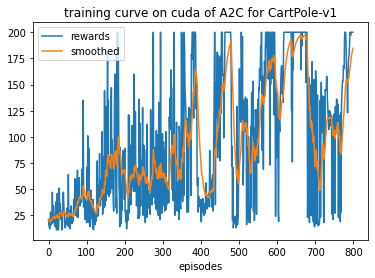

In [17]:
class AlgoConfig:
    '''定义算法相关参数'''
    def __init__(self):
        self.algo_name = 'A2C'
        self.seed = 0
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.continuous = False
        self.gamma = 0.99
        self.actor_lr = 3e-4
        self.critic_lr = 1e-3
        self.actor_hidden_dim = 256
        self.critic_hidden_dim = 256
        self.entropy_coef = 0.001
        self.train_eps = 800
        self.test_eps = 200
        self.eval_eps = 10
        self.eval_per_episode = 50
        self.max_steps = 200
        self.update_freq = 20
        
class EnvConfig:
    '''定义环境相关参数'''
    def __init__(self):
        self.env_id = 'CartPole-v1'
        self.new_step_api = False
        self.render = False
        self.render_mode = 'human'
        
def mergeConfig(ob1,ob2):
    '''合并参数'''
    ob1.__dict__.update(ob2.__dict__)
    return ob1

def print_cfgs(cfg, name = ''):
    '''打印参数'''
    cfg_dict = vars(cfg)
    print(f"{name}:")
    print(''.join(['='] * 80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k, v in cfg_dict.items():
        if v.__class__.__name__ == 'list': # convert list to str
            v = str(v)
        if k in ['model_dir','tb_writter']:
            continue
        if v is None: # avoid NoneType
             v = 'None'
        if "support" in k: # avoid ndarray
            v = str(v[0])
        print(tplt.format(k, v, str(type(v))))
    print(''.join(['='] * 80))
algo_config = AlgoConfig()
env_config = EnvConfig()
cfg = mergeConfig(algo_config,env_config)
# print_cfgs(algo_config,name='AlgoConfig')  
# print_cfgs(env_config,name='EnvConfig')
train(cfg)

start testing!
Episode:1/200,Rewards:200.0,Steps:200
Episode:2/200,Rewards:200.0,Steps:200
Episode:3/200,Rewards:200.0,Steps:200
Episode:4/200,Rewards:200.0,Steps:200
Episode:5/200,Rewards:200.0,Steps:200
Episode:6/200,Rewards:200.0,Steps:200
Episode:7/200,Rewards:200.0,Steps:200
Episode:8/200,Rewards:200.0,Steps:200
Episode:9/200,Rewards:200.0,Steps:200
Episode:10/200,Rewards:200.0,Steps:200
Episode:11/200,Rewards:200.0,Steps:200
Episode:12/200,Rewards:200.0,Steps:200
Episode:13/200,Rewards:200.0,Steps:200
Episode:14/200,Rewards:200.0,Steps:200
Episode:15/200,Rewards:200.0,Steps:200
Episode:16/200,Rewards:200.0,Steps:200
Episode:17/200,Rewards:200.0,Steps:200
Episode:18/200,Rewards:200.0,Steps:200
Episode:19/200,Rewards:200.0,Steps:200
Episode:20/200,Rewards:200.0,Steps:200
Episode:21/200,Rewards:200.0,Steps:200
Episode:22/200,Rewards:200.0,Steps:200
Episode:23/200,Rewards:200.0,Steps:200
Episode:24/200,Rewards:200.0,Steps:200
Episode:25/200,Rewards:200.0,Steps:200
Episode:26/200,Rewa

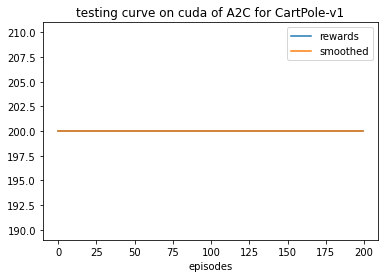

In [18]:
test(cfg)